## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC), implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of:
- a flag that specifies the type of message ('HEAD', which in this case is always 1),
- two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL')
- the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). 

Each TDC count corresponds to 25/30 ns, *whereas a unit of BX_COUNTER corresponds to 25 ns*, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [ ]:
# -L option: follow the redirection link to the actual file
!curl -L -O  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   123  100   123    0     0    429      0 --:--:-- --:--:-- --:--:--   430
100    17  100    17    0     0     16      0  0:00:01  0:00:01 --:--:--     0
100 31.6M  100 31.6M    0     0  9789k      0  0:00:03  0:00:03 --:--:-- 20.4M


1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

### Request 1

In [14]:
# Request 1
import csv
import pandas as pd
import numpy as np

In [15]:
filename = "data_000637.txt"
# inspect how many rows are there in the file

with open(filename, mode= 'r', ) as f:
    reader = csv.reader(f, delimiter=',')  # Specify ',' as the delimiter
    # print first 5 row to ensure everything is ok
    for i, row in enumerate(reader):
        print(row)
        if i == 5:
            break
    # now count the rows
    nrows = sum(1 for _ in reader)

f.close()
print(f"number of rows in the file: {nrows}")

['HEAD', 'FPGA', 'TDC_CHANNEL', 'ORBIT_CNT', 'BX_COUNTER', 'TDC_MEAS']
['1', '0', '123', '3869200167', '2374', '26']
['1', '0', '124', '3869200167', '2374', '27']
['1', '0', '63', '3869200167', '2553', '28']
['1', '0', '64', '3869200167', '2558', '19']
['1', '0', '64', '3869200167', '2760', '25']
number of rows in the file: 1310715


In [33]:
N = np.power(10, 6)
df = pd.read_csv(filepath_or_buffer= filename, nrows= (N + 1))
# nrows : int, optional
# Number of rows of file to read. Useful for reading pieces of large files
df.tail(120)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
999881,1,0,58,3869209011,128,21
999882,1,1,1,3869209011,137,6
999883,1,0,59,3869209011,129,29
999884,1,0,62,3869209011,137,27
999885,1,0,47,3869209011,136,12
...,...,...,...,...,...,...
999996,1,0,51,3869209011,2561,12
999997,1,0,61,3869209011,2562,2
999998,1,0,50,3869209011,2563,4
999999,1,0,60,3869209011,2688,25


### Request 2

TCD_MEAS is the last (smallest unit of measure), like the seconds in a unit system hours:minutes:seconds

For the seconds counter, I know that it ranges in [0, 60] and then resets. But for the TDC_MEAS counter, which is totally arbitrary, I need to find out the range.

To do it I use statistics: the dataset is very large (one million measures), and I expect the sampling times to be a uniform random variable. Hence, if I plot the histogram of TDC_MEAS, I expect to find the whole range of values.

np.int64(29)

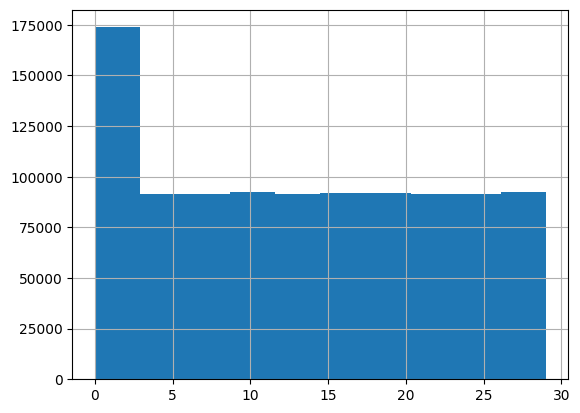

In [29]:
df['TDC_MEAS'].hist()
df['TDC_MEAS'].max()

Answer: there are 29 TDC_MEAS in a BX counter!

i.e. TCD_MEAS is a unit that goes from 0 to 29 and then resets

np.int64(3563)

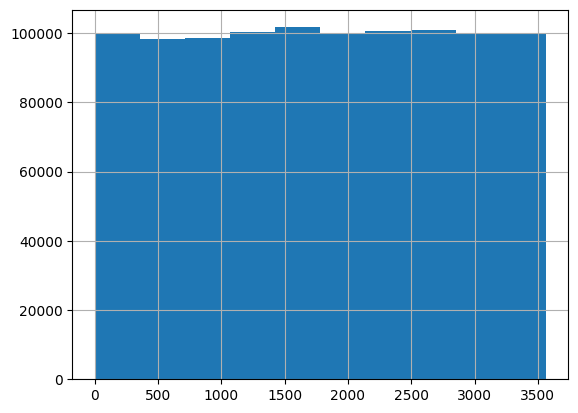

In [30]:
df['BX_COUNTER'].hist()
df['BX_COUNTER'].max()

Summary:

- TCD_MEAS ranges in [0, 29] (extrema included)
- BX_COUNTER ranges in [0, 3563] (extrema included)

The answer to request n. 2 is: $x = 3564$ 
there are $3564$ BX_COUNTER units in a ORBIT_CNT


**ORBIT_CNT::BX_COUNTER::TCD_MEAS**

**[0, ..]::[0, 3563]::[0, 29]**


1 tcd = 25/30 ns
1 bx_counter = 25 ns

hence 1 orbit_counter = $25\,ns \cdot 3564$ = 

### Request 3

Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

<Axes: >

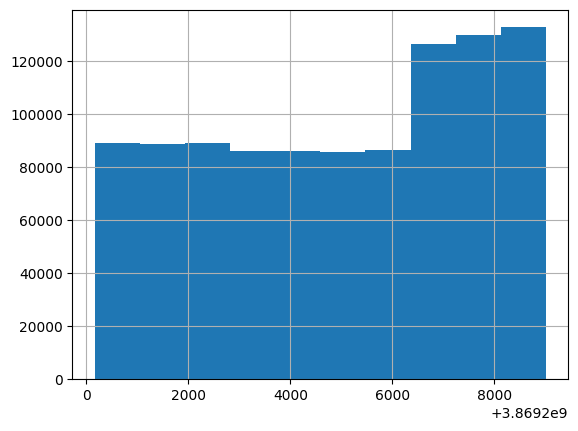

In [ ]:
df['ORBIT_CNT'].hist(bins = 10)
num_orbs_counts = 